<a href="https://colab.research.google.com/github/uegn/Yatogami7618/blob/master/Stock_LSTM_future_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import pandas_datareader as web 
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

a=0
import datetime
tomorrow = datetime.date.today() + datetime.timedelta(days=a)
tomorrow = tomorrow.strftime("%Y-%m-%d")
print('Tomorrow is:',tomorrow)

data_original = web.DataReader('M', data_source='yahoo', start='1900-01-01' , end='now')

# line = pd.to_datetime(tomorrow, format="%Y-%m-%d")
# new_row = pd.DataFrame( index=[line])
# data_original = pd.concat([data_original, pd.DataFrame(new_row)], ignore_index=False)

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


Tomorrow is: 2020-04-28


In [0]:
ratio = .9
data_close = data_original.filter(['Close'])
data_set = data_close.values
train_len = math.ceil(len(data_set) * ratio)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data_set)

train_data = scaled_data[0:train_len,:]
amount_of_day = 253

xtrain = []
ytrain = []
for i in range(amount_of_day, len(train_data)):
  xtrain.append(train_data[i-amount_of_day:i,0])
  ytrain.append(train_data[i,0])

xtrain, ytrain = np.array(xtrain), np.array(ytrain)
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], 1))

In [3]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(xtrain.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(xtrain, ytrain, batch_size=1, epochs=1)

Epoch 1/1
6146/6146 [==============================] - 937s 152ms/step - loss: 7.2366e-04


In [0]:
# test_data = scaled_data[train_len-amount_of_day: , :]
# xtest = []
# ytest = data_set[train_len:,:]
# for i in range(amount_of_day, len(test_data)):
#   xtest.append(test_data[i-amount_of_day:i, 0])

# array_xtest = np.array(xtest)
# array_xtest = np.reshape(array_xtest, (array_xtest.shape[0], array_xtest.shape[1], 1))
# prediction = scaler.inverse_transform(model.predict(array_xtest))

In [5]:
day_in_future = 14
for i in range(day_in_future):
  the_next_day = datetime.date.today() + datetime.timedelta(days=i)
  new_row = pd.DataFrame(index=[pd.to_datetime(the_next_day.strftime("%Y-%m-%d"), format="%Y-%m-%d")])
  data_close = pd.concat([data_close, pd.DataFrame(new_row)], ignore_index=False)

  test_data = scaled_data[train_len-amount_of_day: , :]
  xtest = []
  ytest = data_set[train_len:,:]
  for j in range(amount_of_day, len(test_data)):
    xtest.append(test_data[j-amount_of_day:j, 0])
  array_xtest = np.array(xtest)
  array_xtest = np.reshape(array_xtest, (array_xtest.shape[0], array_xtest.shape[1], 1))
  prediction = scaler.inverse_transform(model.predict(array_xtest))

  data_close['Close'][-1] = prediction[-1]
  train_len = math.ceil(len(data_close.values) * ratio)
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(data_close.values)
  print(prediction[-1])

[7.231986]
[7.4636326]
[8.303499]
[9.0629225]
[9.788858]
[10.469906]
[11.103874]
[11.693437]
[12.2443]
[12.763747]
[13.259405]
[13.738371]
[14.206654]
[14.668901]


In [24]:
data_close[-20:]

,Close
2020-04-20,5.310000
2020-04-21,5.220000
2020-04-22,4.820000
2020-04-23,4.890000
2020-04-24,5.020000
2020-04-27,5.500000
2020-04-28,7.231986
2020-04-29,7.463633
2020-04-30,8.303499
2020-05-01,9.062922


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


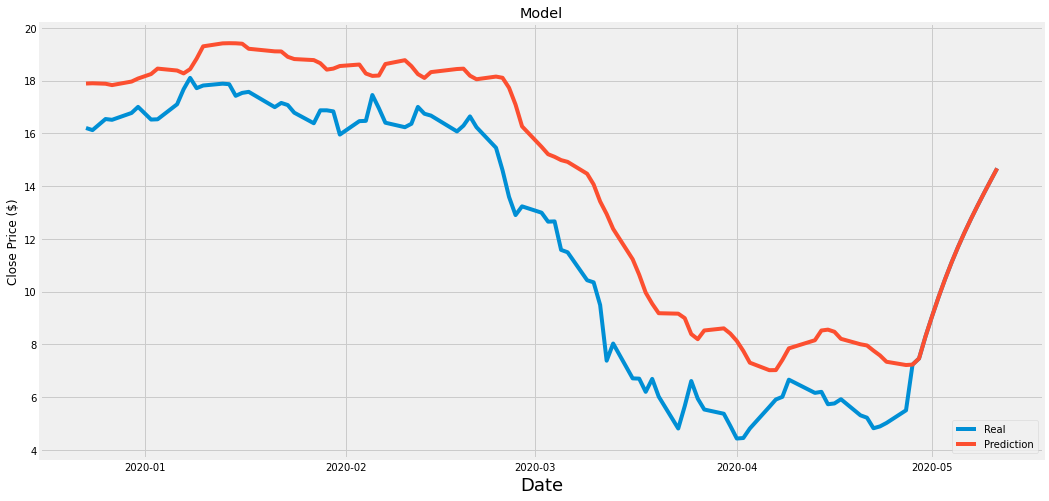

In [27]:
last_th_day = 100
train = data_close[:train_len]
valid = data_close[train_len:]
valid['Prediction'] = prediction
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price ($)')
# plt.plot(train['Close'][-last_th_day:])
plt.plot(valid[['Close', 'Prediction']][-last_th_day:])
plt.legend(['Real', 'Prediction'], loc='lower right')
plt.show()
